In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import os
import numpy as np
from os import listdir
from pathlib import Path
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import h5py
import pydicom as dicom
import matplotlib.pyplot as plt
from dicompylercore import dicomparser, dvh, dvhcalc
from dicom_contour.contour import get_contour_file,get_roi_names, coord2pixels, cfile2pixels, plot2dcontour, slice_order, get_contour_dict, get_data,  create_image_mask_files
from preprocessing.get_plan_from_dicom import Plan, plot_DVH, structure_range, img_cut, resample
from preprocessing.get_plan_from_dicom import plot_3d_img, plan_unit_test
from preprocessing.generate_data import get_plans_unit_test
from util import *
from config import *
from preprocessing.generate_data import get_plans
from dicom_contour.contour import get_ct_name_dict
from dicom_contour.dose import build_dose_volume
import pickle
from PIL import Image, ImageDraw
from copy import deepcopy
import math
#from model_training_evaluation.training import train_nn_model, run_training
from model_training_evaluation.predicting import predict_evaluation, evaluate, predict_batch, predict_unit_test
from model_training_evaluation.training import training_unit_test

C:\Users\Varian600c\.conda\envs\tf-gpu\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [56]:
if __name__ == '__main__':
    dicom_path = './dicom_data'
    plan_save_path = './Data/plans'
    dataset_save_path = './Data/npy_dataset'
    
    get_plans(dicom_path, section = 'Lungs', section_size = section_size, matrix_size = matrix_size, plan_save_path = plan_save_path, dataset_save_path = dataset_save_path, save_npy = True, batch_size = 1)

work on patient  TMI_Evans
work on RS structure  TMLI 17423 Body
start structure extraction
finish extract contour
Elapsed time: 131.0374 seconds
start extract dose
finish extract dose
Elapsed time: 36.1482 seconds
BODY <--------> BODY
PTV_Ribs <--------> PTV_Ribs
PTV_VExP <--------> PTV_VExP
PTV_SpCord <--------> PTV_SpCord
PTV_LN <--------> PTV_LN
PTV_Spleen <--------> PTV_Spleen
PTV_Liver <--------> PTV_Liver
Lungs <--------> Lungs
Heart <--------> Heart
Esophagus <--------> Esophagus
GI_Upper <--------> GI_Upper
Breasts <--------> Breasts
x_dim, y_dim, z_dim [109, 349] [94, 414] [75, 111]
one structure Mask Data Shape: (16, 96, 128, 12)
scan shape and dose shape= (1, 16, 96, 128, 12) (1, 16, 96, 128, 1)
work on patient  TMI_Kane
work on RS structure  CT_TMI_11/18/19
start structure extraction
finish extract contour
Elapsed time: 124.7916 seconds
start extract dose
finish extract dose
Elapsed time: 39.4745 seconds
BODY <--------> BODY
PTV_Ribs <--------> PTV_Ribs
PTV_VExP <-------->

work on RS structure  CT_TMI_11/18/19
start structure extraction
finish extract contour
Elapsed time: 128.2233 seconds
start extract dose
finish extract dose
Elapsed time: 39.5797 seconds
BODY <--------> BODY
PTV_Ribs <--------> PTV_Ribs
PTV_VExP <--------> PTV_VExP
PTV_SpCord <--------> PTV_SpCord
PTV_LN <--------> PTV_LN
PTV_Spleen <--------> PTV_Spleen
PTV_Liver <--------> PTV_Liver
Lungs <--------> Lungs
Heart <--------> Heart
Esophagus <--------> Esophagus
GI_Upper <--------> GI_Upper
dict_keys(['Bladder', 'Esophagus+Mar', 'Eyes', 'Eyes+Margin', 'GI_Lower', 'Kidney_L', 'Kidney_R', 'Kidneys', 'Kidneys+Margin', 'Lenses', 'Lung_L', 'Lung_R', 'OpticN/Chiasm', 'OralCavity', 'Parotids', 'PTV_Brain', 'PTV_Skull', 'PTV_Testes', 'Rectum', 'Thyroid', 'Larynx', 'Avoid-post', 'Avoid-ant', 'Avoid-ant1', 'Skin', 'Ring1', 'BODY', 'PTV_Ribs', 'PTV_VExP', 'PTV_SpCord', 'PTV_LN', 'PTV_Spleen', 'PTV_Liver', 'Lungs', 'Heart', 'Esophagus', 'GI_Upper', 'Breasts'])


<IPython.core.display.Javascript object>


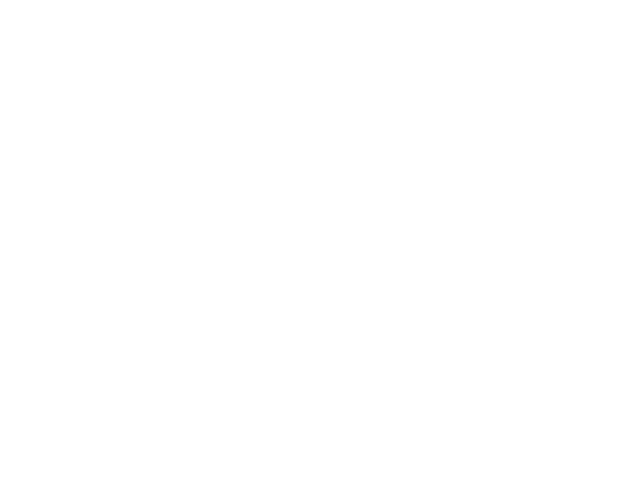

In [14]:
plan = plan_unit_test()

<IPython.core.display.Javascript object>


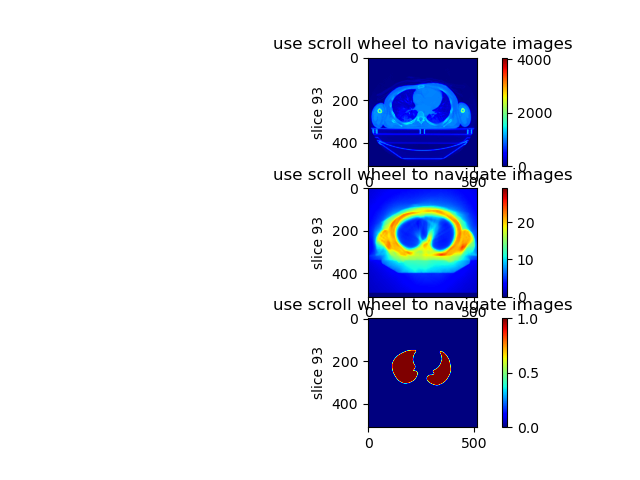

In [27]:
organ = 'Lungs'
fig, (ax1, ax2, ax3)= plt.subplots(3, 1)
max_img = np.max(plan.img_volume.flatten())
max_dose = np.max(plan.dose_volume.flatten())
tracker1 = IndexTracker(ax1, plan.img_volume, fig,0,max_img)
fig.canvas.mpl_connect('scroll_event', tracker1.onscroll)
tracker2 = IndexTracker(ax2, plan.dose_volume, fig,0,max_dose)
fig.canvas.mpl_connect('scroll_event', tracker2.onscroll)
tracker3 = IndexTracker(ax3, plan.structures[organ]['mask'], fig,0,1)
fig.canvas.mpl_connect('scroll_event', tracker3.onscroll)
#tracker4 = IndexTracker(ax4, plan.structures[organ]['contour'], fig,0,1)
#fig.canvas.mpl_connect('scroll_event', tracker4.onscroll)
plt.show()

In [43]:
zmin_body,zmax_body,xmin_body,xmax_body,ymin_body,ymax_body = plan.structure_range('BODY')
section = 'Lungs'
zmin,zmax,xmin,xmax,ymin,ymax = plan.structure_range(section)

origin = [math.floor((zmin+zmax)/2), math.floor((xmin_body+xmax_body)/2), math.floor((ymin_body+ymax_body)/2)]

In [44]:
z_dim = int(section_size[0]*10 / plan.slice_thickness)
x_dim = int(section_size[1]*10 / plan.Row_Spacing); y_dim = int(section_size[2]*10 / plan.Col_Spacing)
plan_test = deepcopy(plan)
print(x_dim, y_dim, z_dim)
print(origin)

384 512 36
[98, 213, 249]


In [40]:
plan.Col_Spacing

0.976562

In [45]:
plan_test.img_cut(x_dim, y_dim, z_dim, origin)

<IPython.core.display.Javascript object>


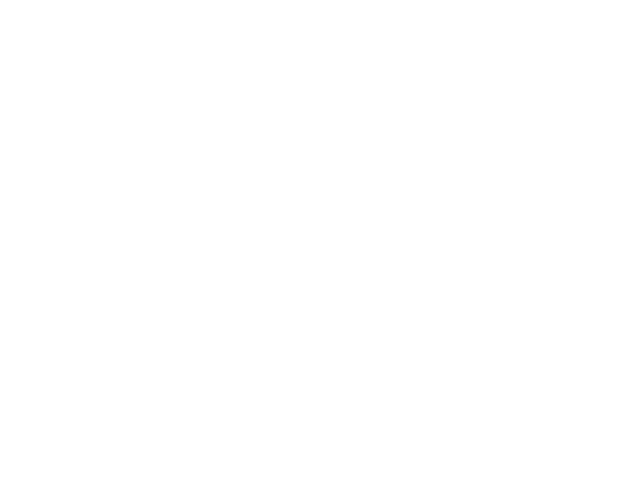

ValueError: zero-size array to reduction operation maximum which has no identity

In [46]:
organ = 'Lungs'
fig, (ax1, ax2, ax3)= plt.subplots(3, 1)
max_img = np.max(plan_test.img_volume.flatten())
max_dose = np.max(plan_test.dose_volume.flatten())
tracker1 = IndexTracker(ax1, plan_test.img_volume, fig,0,max_img)
fig.canvas.mpl_connect('scroll_event', tracker1.onscroll)
tracker2 = IndexTracker(ax2, plan_test.dose_volume, fig,0,max_dose)
fig.canvas.mpl_connect('scroll_event', tracker2.onscroll)
tracker3 = IndexTracker(ax3, plan_test.structures[organ]['mask'], fig,0,1)
fig.canvas.mpl_connect('scroll_event', tracker3.onscroll)
#tracker4 = IndexTracker(ax4, plan.structures[organ]['contour'], fig,0,1)
#fig.canvas.mpl_connect('scroll_event', tracker4.onscroll)
plt.show()

In [20]:
scans, dose_imgs = get_plans_unit_test()

work on patient  TMI_Kane
work on RS structure  CT_TMI_11/18/19
start structure extraction
finish extract contour
Elapsed time: 124.2425 seconds
start extract dose
finish extract dose
Elapsed time: 38.7863 seconds
BODY <--------> BODY
PTV_Ribs <--------> PTV_Ribs
PTV_VExP <--------> PTV_VExP
PTV_SpCord <--------> PTV_SpCord
PTV_LN <--------> PTV_LN
PTV_Spleen <--------> PTV_Spleen
PTV_Liver <--------> PTV_Liver
Lungs <--------> Lungs
Heart <--------> Heart
Esophagus <--------> Esophagus
GI_Upper <--------> GI_Upper
one structure Mask Data Shape: (16, 64, 128, 12)
scan shape and dose shape= (1, 16, 64, 128, 12) (1, 16, 64, 128, 1)
Structure Masks Data Shape: (1, 16, 64, 128, 12)
Dose Data Shape: (1, 16, 64, 128, 1)
NPY dataset saved!
work on patient  TMI_Kane
work on RS structure  CT_TMI_11/18/19
start structure extraction
finish extract contour
Elapsed time: 135.4214 seconds
start extract dose
finish extract dose
Elapsed time: 38.6983 seconds
BODY <--------> BODY
PTV_Ribs <--------> PT

<IPython.core.display.Javascript object>


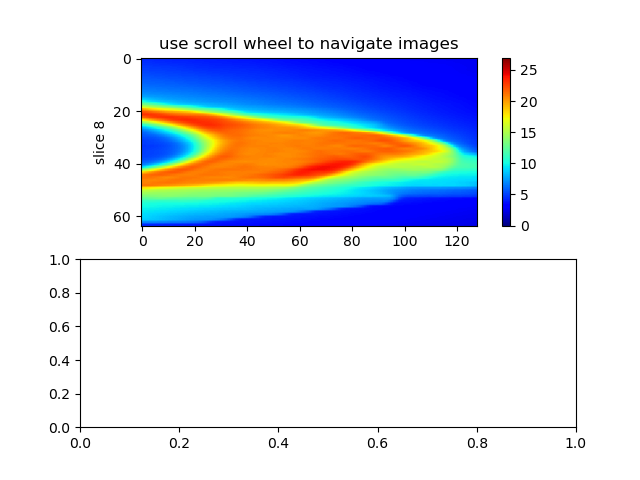

In [25]:
dose = np.squeeze(dose_imgs)
fig, (ax1, ax2)= plt.subplots(2, 1)
max_dose = np.max((dose).flatten())
tracker1 = IndexTracker(ax1, dose, fig,0,max_dose)

In [3]:
plan = pickle.load(open("plan_Chavez.pickle", "rb", -1))

<IPython.core.display.Javascript object>


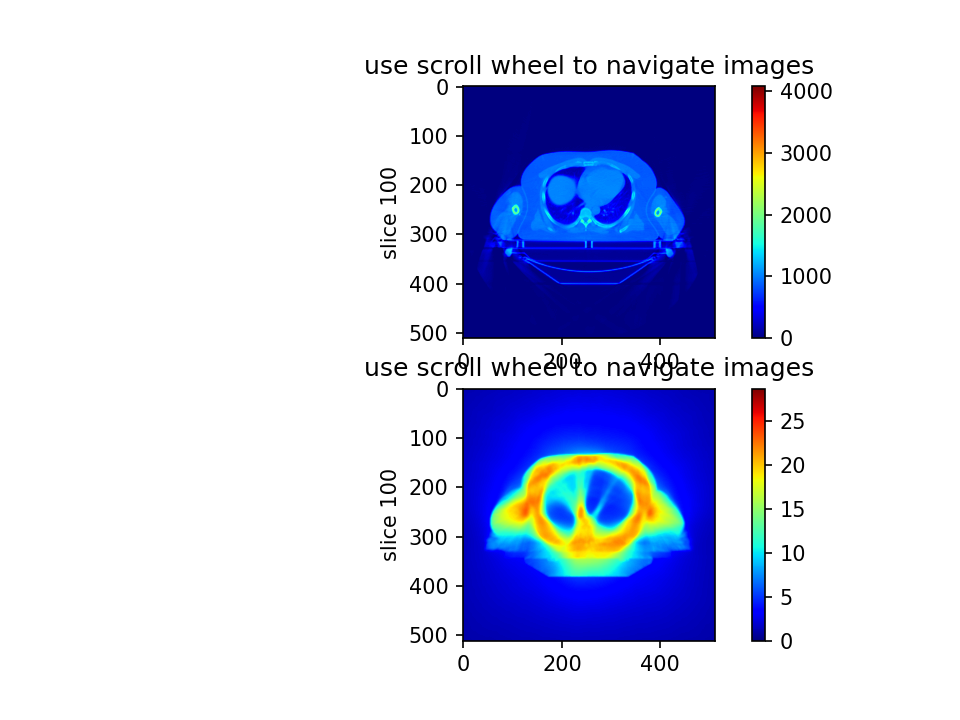

<IPython.core.display.Javascript object>


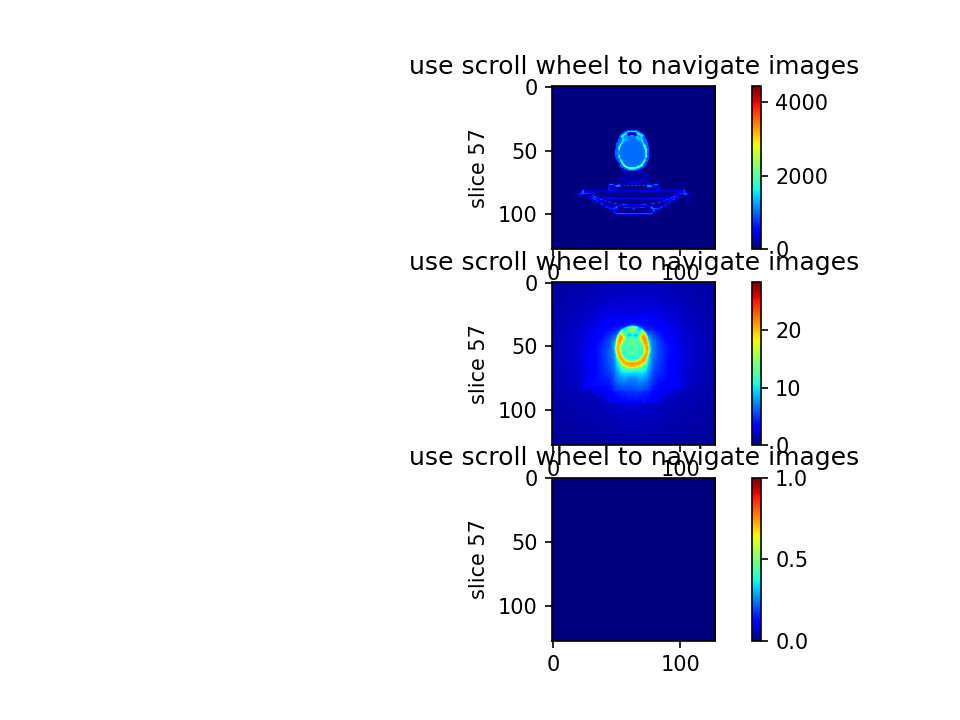

In [203]:
plan_new = deepcopy(plan)
plan_new = resample(plan_new,x_dim=128, y_dim=128, z_dim=64)
organ = 'Lungs'

print('old dimenstion is ', plan.img_volume.shape())
print('new dimenstion is ', plan_new.img_volume.shape())

fig, (ax1, ax2, ax3)= plt.subplots(3, 1)
max_img = np.max(plan_new.img_volume.flatten())
max_dose = np.max(plan_new.dose_volume.flatten())
tracker1 = IndexTracker(ax1, plan_new.img_volume, fig,0,max_img)
fig.canvas.mpl_connect('scroll_event', tracker1.onscroll)
tracker2 = IndexTracker(ax2, plan_new.dose_volume, fig,0,max_dose)
fig.canvas.mpl_connect('scroll_event', tracker2.onscroll)
tracker3 = IndexTracker(ax3, plan_new.structures[organ]['mask'], fig,0,1)
fig.canvas.mpl_connect('scroll_event', tracker3.onscroll)
plt.show()

x_dim:122, y_dim:179, z_dim:29, origin:[104, 221, 255]


<IPython.core.display.Javascript object>


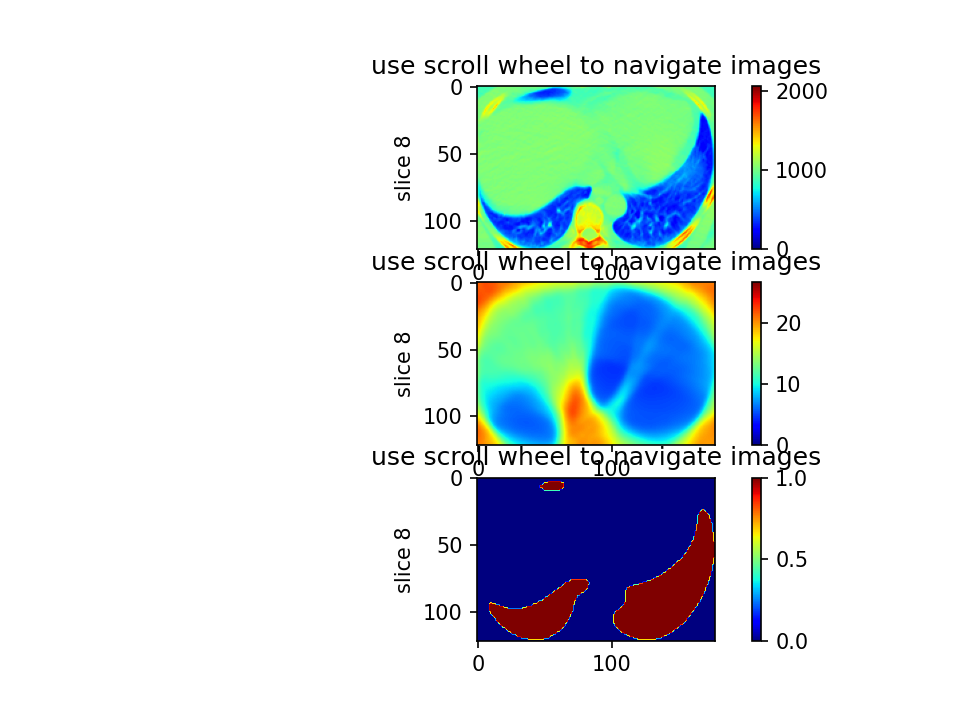

In [192]:
plan_new = deepcopy(plan)
zmin,zmax,xmin,xmax,ymin,ymax = structure_range(plan_new, 'Lungs')
origin = [math.floor((zmin+zmax)/2), math.floor((xmin+xmax)/2), math.floor((ymin+ymax)/2)]
x_dim = xmax-xmin+4; z_dim = zmax-zmin+4; y_dim = ymax-ymin+4
print('x_dim:{}, y_dim:{}, z_dim:{}, origin:{}'.format(x_dim,y_dim,z_dim,origin))
plan_new = img_cut(plan_new, x_dim, y_dim, z_dim, origin)
organ = 'Lungs'

fig, (ax1, ax2, ax3)= plt.subplots(3, 1)
max_img = np.max(plan_new.img_volume.flatten())
max_dose = np.max(plan_new.dose_volume.flatten())
tracker1 = IndexTracker(ax1, plan_new.img_volume, fig,0,max_img)
fig.canvas.mpl_connect('scroll_event', tracker1.onscroll)
tracker2 = IndexTracker(ax2, plan_new.dose_volume, fig,0,max_dose)
fig.canvas.mpl_connect('scroll_event', tracker2.onscroll)
tracker3 = IndexTracker(ax3, plan_new.structures[organ]['mask'], fig,0,1)
fig.canvas.mpl_connect('scroll_event', tracker3.onscroll)
plt.show()

<IPython.core.display.Javascript object>


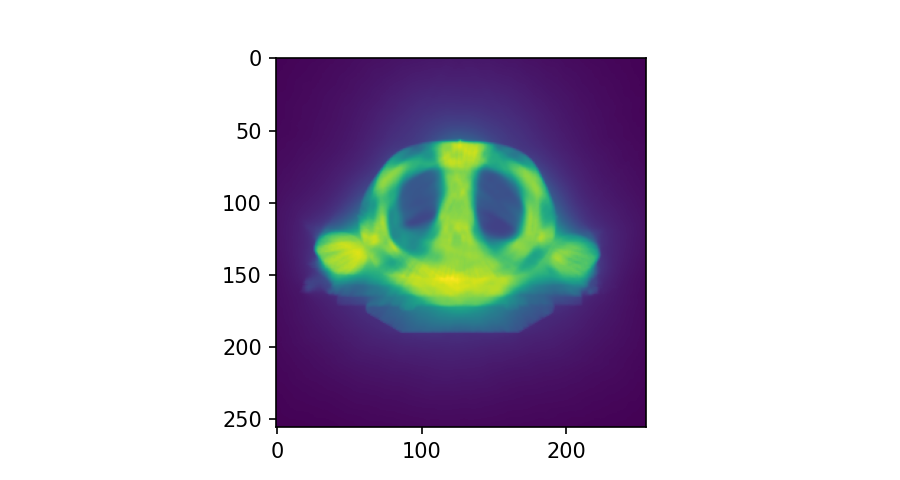

In [118]:
standard_list = ['PTV_Ribs', 'PTV_VExP', 'PTV_SpCord', 'PTV_LN', 'PTV_Spleen', 'PTV_Liver', 'BODY', 'Lungs']
standard_list = ['Heart', 'PTV_SpCord', 'Lung_L','PTV_Skull','Bladder']
plot_DVH(plan, standard_list)

Lungs
True mean organ dose is:  8.015882836100516
True max organ dose is:  26.72603736307324


<IPython.core.display.Javascript object>


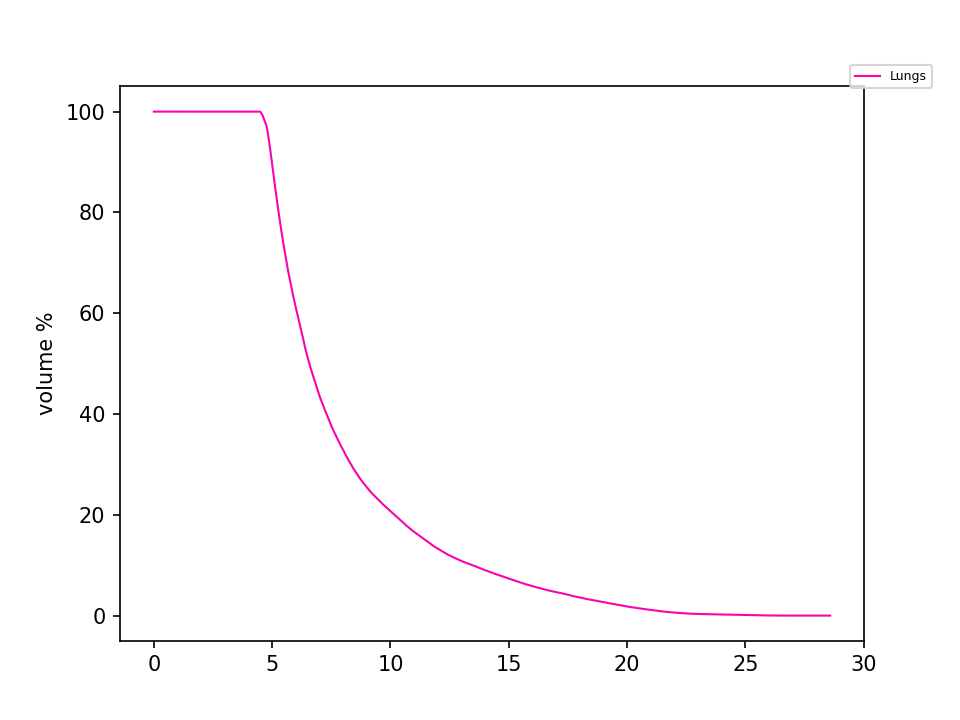

(defaultdict(None, {'Lungs': array([1., 1., 1., ..., 0., 0., 0.])}),
 {'Lungs': 8.015882836100516},
 {'Lungs': 26.72603736307324},
 {'Lungs': 4.847290374411494},
 {'Lungs': 16.67239108130915})

In [196]:
standard_list = ['PTV_Ribs', 'PTV_VExP', 'PTV_SpCord', 'PTV_LN', 'PTV_Spleen', 'PTV_Liver', 'BODY', 'Lungs']
standard_list = ['Lungs']
plot_DVH(plan, standard_list)

Lungs
True mean organ dose is:  7.988167042143717
True max organ dose is:  26.11972649371231


<IPython.core.display.Javascript object>


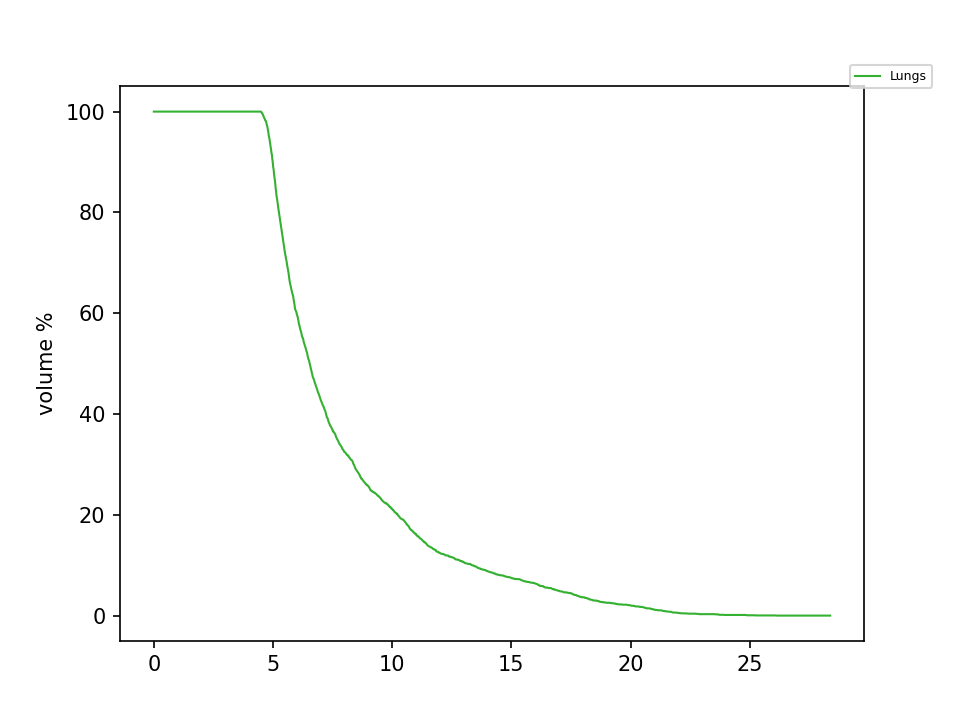

(defaultdict(None, {'Lungs': array([1., 1., 1., ..., 0., 0., 0.])}),
 {'Lungs': 7.988167042143717},
 {'Lungs': 26.11972649371231},
 {'Lungs': 4.840816918198047},
 {'Lungs': 16.92156529763071})

In [206]:
plot_DVH(plan_new, standard_list)

In [289]:
if __name__ == '__main__':
    run_training(train_gan_model = False, input_size = (16, 64, 128, 12), parent_path='Data', training_npy_path = 'Data/npy_dataset/training/' , validation_npy_path = 'Data/npy_dataset/validation/')

NameError: name 'run_training' is not defined

In [43]:
contour_arr_orignal = plan.structures['Ring_1']['contour']

In [54]:
x=np.array([1,2,3])
y=np.array([4,5,6])
z = np.array([7])
xx,yy, zz = np.meshgrid(x,y,z)

In [65]:
dose_plane = dose_vol.interpolating_function(test)

In [46]:
contour_arr_orignal = plan.structures['Ring_1']['contour'][107,:,:]

In [47]:
np.shape(contour_arr_orignal)

(640, 640)

In [67]:
np.shape(dose_plane)

(3, 3)

In [161]:
arrays = [np.random.randn(3, 4) for _ in range(5)]
np.stack(arrays, axis=0).shape
test = np.stack(arrays, axis=0)
test = test>0
test

array([[[ True, False, False, False],
        [False,  True,  True,  True],
        [False,  True,  True,  True]],

       [[False, False, False, False],
        [ True, False, False, False],
        [False,  True, False,  True]],

       [[False, False, False, False],
        [False,  True,  True, False],
        [False,  True, False, False]],

       [[False,  True,  True,  True],
        [False,  True,  True, False],
        [False,  True, False,  True]],

       [[ True, False,  True,  True],
        [ True, False, False, False],
        [False, False,  True,  True]]])

In [164]:
print(test.shape)
(x,y,z) = np.where(test)

(5, 3, 4)


In [5]:
x = np.array([1,2,3])
max(x-2,0)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [274]:
y = 'abd'
y in x

False

In [250]:
data_folder = 'data_Chavez_NEW'
f = loadmat(data_folder)
scan = f['structset_2d_channel']
dose_img = f['doseset_2d']

In [251]:
scan.shape

(28, 128, 256, 13)

In [252]:
dose_img.shape

(28, 128, 256)

In [302]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.test.is_built_with_cuda()

False

In [5]:
training_unit_test()

output shape= (None, 16, 96, 128, 1)
Dose prediction Model Architecture:
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 16, 96, 128, 0                                            
__________________________________________________________________________________________________
conv3d_68 (Conv3D)              (None, 16, 96, 128,  5200        input_4[0][0]                    
__________________________________________________________________________________________________
concatenate_63 (Concatenate)    (None, 16, 96, 128,  0           input_4[0][0]                    
                                                                 conv3d_68[0][0]                  
__________________________________________________________________________________________________
conv3d_69 (Con

Epoch 1/10
2/2 [==============================] - ETA: 0s - loss: 153.6165 - mean_squared_error: 153.6165 - acc: 0.0000e+00
Epoch 00001: val_loss improved from inf to 141.72522, saving model to Data/Checkpoints_UnetDense\best_weights.h5
2/2 [==============================] - 2s 1s/step - loss: 153.6165 - mean_squared_error: 153.6165 - acc: 0.0000e+00 - val_loss: 141.7252 - val_mean_squared_error: 141.7252 - val_acc: 0.0000e+00
Epoch 2/10
2/2 [==============================] - ETA: 0s - loss: 142.9086 - mean_squared_error: 142.9086 - acc: 0.0000e+00
Epoch 00002: val_loss did not improve from 141.72522
2/2 [==============================] - 2s 916ms/step - loss: 142.9086 - mean_squared_error: 142.9086 - acc: 0.0000e+00 - val_loss: 144.5614 - val_mean_squared_error: 144.5614 - val_acc: 0.0000e+00
Epoch 3/10
2/2 [==============================] - ETA: 0s - loss: 146.9110 - mean_squared_error: 146.9110 - acc: 0.0000e+00
Epoch 00003: val_loss improved from 141.72522 to 140.20334, saving mode

work on test patient  patient_1
BODY
True mean organ dose is:  16.389389
True max organ dose is:  25.537466
PTV_Ribs
True mean organ dose is:  19.54107
True max organ dose is:  24.427658
PTV_VExP
True mean organ dose is:  16.130733
True max organ dose is:  24.82839
PTV_SpCord
True mean organ dose is:  20.738586
True max organ dose is:  22.122698
PTV_LN
True mean organ dose is:  20.215515
True max organ dose is:  24.671274
PTV_Spleen
True mean organ dose is:  20.885763
True max organ dose is:  24.460972
PTV_Liver
True mean organ dose is:  12.435474
True max organ dose is:  18.56007
Lungs
True mean organ dose is:  8.172852
True max organ dose is:  23.204603
Heart
True mean organ dose is:  8.238975
True max organ dose is:  19.372377
Esophagus
True mean organ dose is:  6.8729396
True max organ dose is:  17.392906
GI_Upper
True mean organ dose is:  11.6298275
True max organ dose is:  23.21982
Breasts
True mean organ dose is:  14.141489
True max organ dose is:  23.862206


<IPython.core.display.Javascript object>


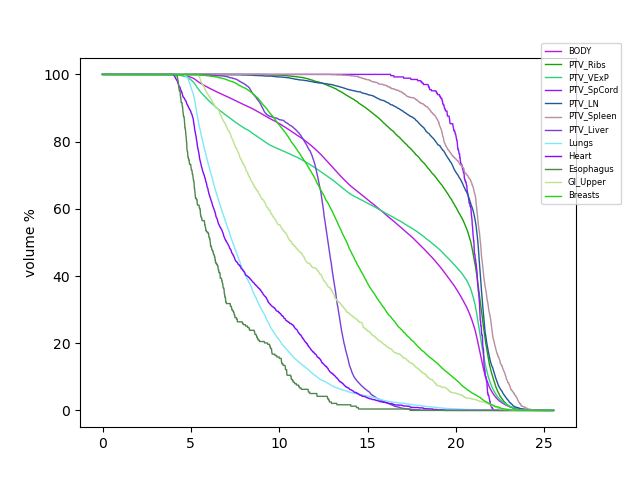

BODY
True mean organ dose is:  13.389389
True max organ dose is:  22.537466
PTV_Ribs
True mean organ dose is:  16.541073
True max organ dose is:  21.427658
PTV_VExP
True mean organ dose is:  13.130733
True max organ dose is:  21.82839
PTV_SpCord
True mean organ dose is:  17.738586
True max organ dose is:  19.122698
PTV_LN
True mean organ dose is:  17.215515
True max organ dose is:  21.671274
PTV_Spleen
True mean organ dose is:  17.885763
True max organ dose is:  21.460972
PTV_Liver
True mean organ dose is:  9.435474
True max organ dose is:  15.56007
Lungs
True mean organ dose is:  5.1728525
True max organ dose is:  20.204603
Heart
True mean organ dose is:  5.2389746
True max organ dose is:  16.372377
Esophagus
True mean organ dose is:  3.8729393
True max organ dose is:  14.392906
GI_Upper
True mean organ dose is:  8.6298275
True max organ dose is:  20.21982
Breasts
True mean organ dose is:  11.141489
True max organ dose is:  20.862206


<IPython.core.display.Javascript object>


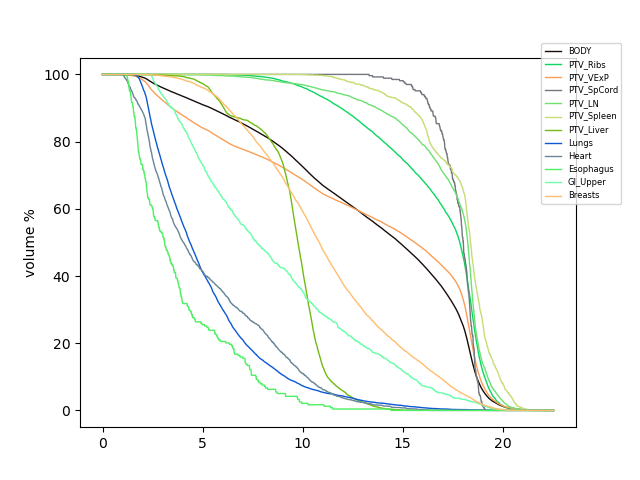

<IPython.core.display.Javascript object>


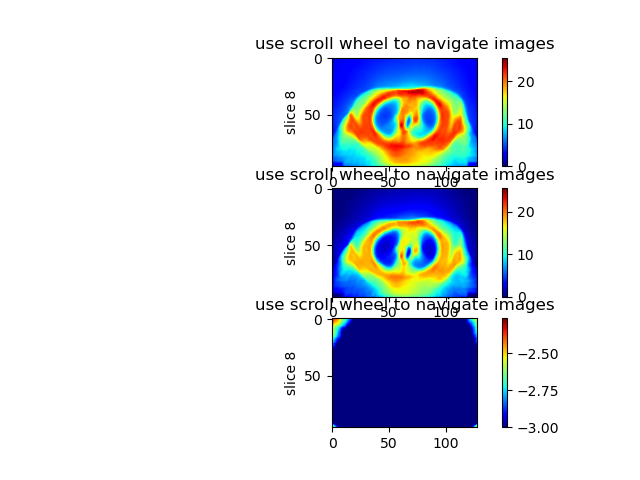

<IPython.core.display.Javascript object>


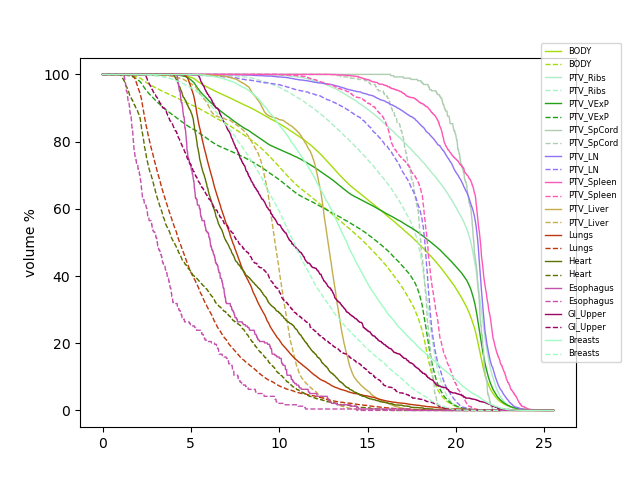

,Organ,Dmean,Dmax,D95,D98,D5,D2
0,BODY,-0.183045,-0.117474,-0.468720,-0.558737,-0.135829,-0.131877
1,PTV_Ribs,-0.153523,-0.122812,-0.223176,-0.249853,-0.133548,-0.131780
2,PTV_VExP,-0.185980,-0.120829,-0.544437,-0.589781,-0.135206,-0.131812
3,PTV_SpCord,-0.144658,-0.135607,-0.161056,-0.168013,-0.136604,-0.136470
4,PTV_LN,-0.148401,-0.121599,-0.210124,-0.257788,-0.132374,-0.129651
5,PTV_Spleen,-0.143639,-0.122644,-0.178500,-0.197502,-0.128603,-0.127015
6,PTV_Liver,-0.241245,-0.161637,-0.355850,-0.388796,-0.197704,-0.185521
7,Lungs,-0.367069,-0.129285,-0.591998,-0.615191,-0.205096,-0.175173
8,Heart,-0.364123,-0.154860,-0.672205,-0.709380,-0.208070,-0.182821
9,Esophagus,-0.436494,-0.172484,-0.689434,-0.702312,-0.255759,-0.232246


work on test patient  patient_2
BODY
True mean organ dose is:  15.39136
True max organ dose is:  28.23615
PTV_Ribs
True mean organ dose is:  16.49697
True max organ dose is:  26.2508
PTV_VExP
True mean organ dose is:  19.24489
True max organ dose is:  27.286682
PTV_SpCord
True mean organ dose is:  19.529453
True max organ dose is:  21.991417
PTV_LN
True mean organ dose is:  17.38732
True max organ dose is:  27.49138
PTV_Spleen
True mean organ dose is:  19.699053
True max organ dose is:  21.919924
PTV_Liver
True mean organ dose is:  13.558965
True max organ dose is:  22.333504
Lungs
True mean organ dose is:  10.978504
True max organ dose is:  24.967419
Heart
True mean organ dose is:  7.664198
True max organ dose is:  21.178871
Esophagus
True mean organ dose is:  15.669184
True max organ dose is:  24.95899
GI_Upper
True mean organ dose is:  16.53762
True max organ dose is:  22.935917
Breasts  not exist


<IPython.core.display.Javascript object>


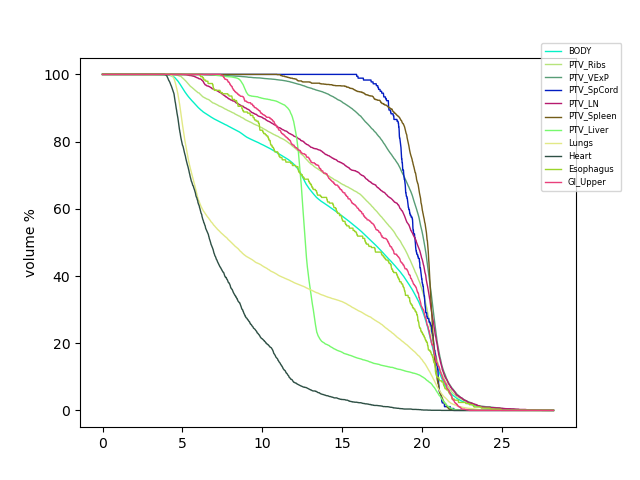

BODY
True mean organ dose is:  12.39138
True max organ dose is:  25.23615
PTV_Ribs
True mean organ dose is:  13.496968
True max organ dose is:  23.2508
PTV_VExP
True mean organ dose is:  16.24489
True max organ dose is:  24.286682
PTV_SpCord
True mean organ dose is:  16.529453
True max organ dose is:  18.991417
PTV_LN
True mean organ dose is:  14.387321
True max organ dose is:  24.49138
PTV_Spleen
True mean organ dose is:  16.699053
True max organ dose is:  18.919924
PTV_Liver
True mean organ dose is:  10.558964
True max organ dose is:  19.333504
Lungs
True mean organ dose is:  7.9785023
True max organ dose is:  21.967419
Heart
True mean organ dose is:  4.6641974
True max organ dose is:  18.178871
Esophagus
True mean organ dose is:  12.669184
True max organ dose is:  21.95899
GI_Upper
True mean organ dose is:  13.537621
True max organ dose is:  19.935917
Breasts  not exist


<IPython.core.display.Javascript object>


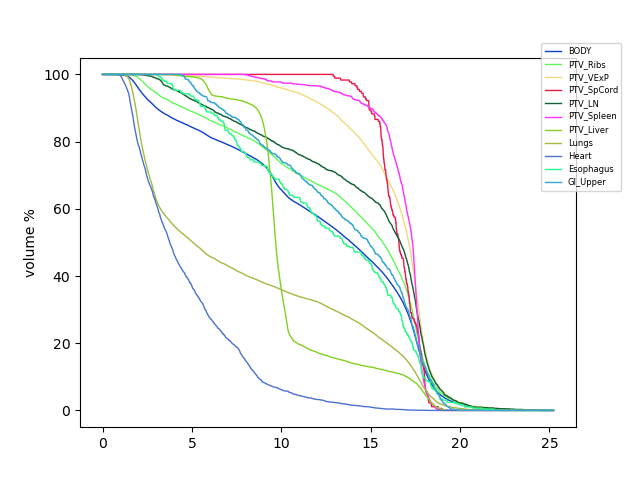

<IPython.core.display.Javascript object>


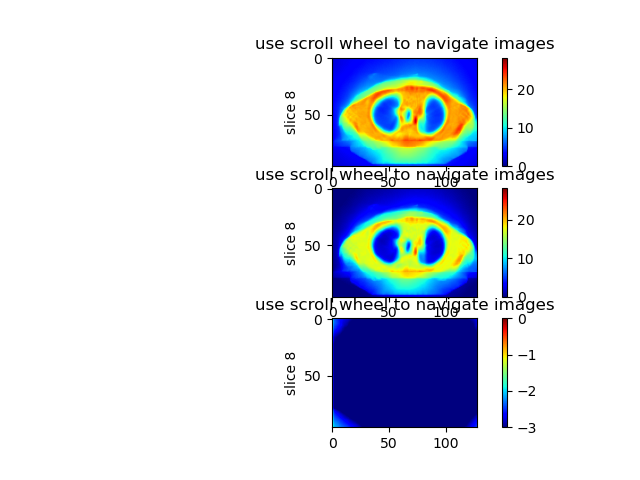

<IPython.core.display.Javascript object>


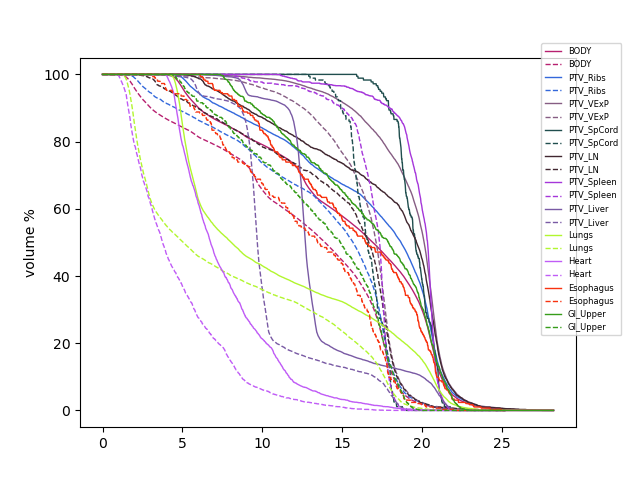

,Organ,Dmean,Dmax,D95,D98,D5,D2
0,BODY,-0.194913,-0.106247,-0.586362,-0.636077,-0.137485,-0.131043
1,PTV_Ribs,-0.181852,-0.114282,-0.511128,-0.576133,-0.136670,-0.129709
2,PTV_VExP,-0.155886,-0.109944,-0.220166,-0.260493,-0.135298,-0.129108
3,PTV_SpCord,-0.153614,-0.136417,-0.173042,-0.178287,-0.141448,-0.141261
4,PTV_LN,-0.172539,-0.109125,-0.415220,-0.477807,-0.135924,-0.129108
5,PTV_Spleen,-0.152292,-0.136862,-0.190951,-0.227748,-0.142092,-0.139763
6,PTV_Liver,-0.221256,-0.134327,-0.333901,-0.346425,-0.142886,-0.139763
7,Lungs,-0.273261,-0.120157,-0.640879,-0.662050,-0.141331,-0.137404
8,Heart,-0.391430,-0.141651,-0.680191,-0.721270,-0.220166,-0.183162
9,Esophagus,-0.191459,-0.120197,-0.408167,-0.465309,-0.138229,-0.132322


work on test patient  patient_3
BODY
True mean organ dose is:  15.483254
True max organ dose is:  25.42727
PTV_Ribs
True mean organ dose is:  18.94304
True max organ dose is:  24.134563
PTV_VExP
True mean organ dose is:  14.711557
True max organ dose is:  25.42727
PTV_SpCord
True mean organ dose is:  20.021742
True max organ dose is:  21.200737
PTV_LN
True mean organ dose is:  19.629684
True max organ dose is:  23.052628
PTV_Spleen
True mean organ dose is:  20.599417
True max organ dose is:  21.726841
PTV_Liver
True mean organ dose is:  12.514458
True max organ dose is:  16.39862
Lungs
True mean organ dose is:  8.107888
True max organ dose is:  22.50711
Heart
True mean organ dose is:  7.015418
True max organ dose is:  19.914865
Esophagus
True mean organ dose is:  6.2188964
True max organ dose is:  16.30576
GI_Upper
True mean organ dose is:  10.074879
True max organ dose is:  19.3943
Breasts
True mean organ dose is:  20.119835
True max organ dose is:  23.429369


<IPython.core.display.Javascript object>


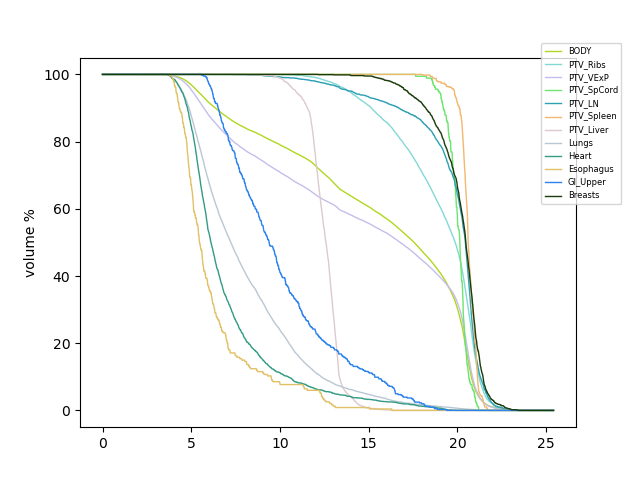

BODY
True mean organ dose is:  12.483254
True max organ dose is:  22.42727
PTV_Ribs
True mean organ dose is:  15.943041
True max organ dose is:  21.134563
PTV_VExP
True mean organ dose is:  11.711557
True max organ dose is:  22.42727
PTV_SpCord
True mean organ dose is:  17.021742
True max organ dose is:  18.200737
PTV_LN
True mean organ dose is:  16.629684
True max organ dose is:  20.052628
PTV_Spleen
True mean organ dose is:  17.599417
True max organ dose is:  18.726841
PTV_Liver
True mean organ dose is:  9.514457
True max organ dose is:  13.398621
Lungs
True mean organ dose is:  5.107888
True max organ dose is:  19.50711
Heart
True mean organ dose is:  4.015418
True max organ dose is:  16.914865
Esophagus
True mean organ dose is:  3.2188966
True max organ dose is:  13.305759
GI_Upper
True mean organ dose is:  7.0748787
True max organ dose is:  16.3943
Breasts
True mean organ dose is:  17.119833
True max organ dose is:  20.429369


<IPython.core.display.Javascript object>


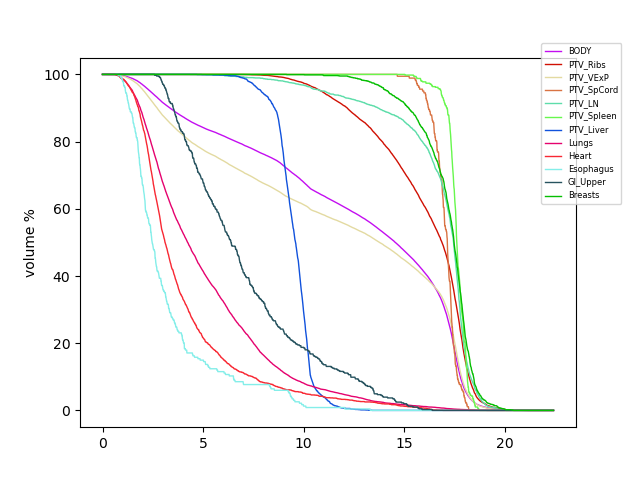

<IPython.core.display.Javascript object>


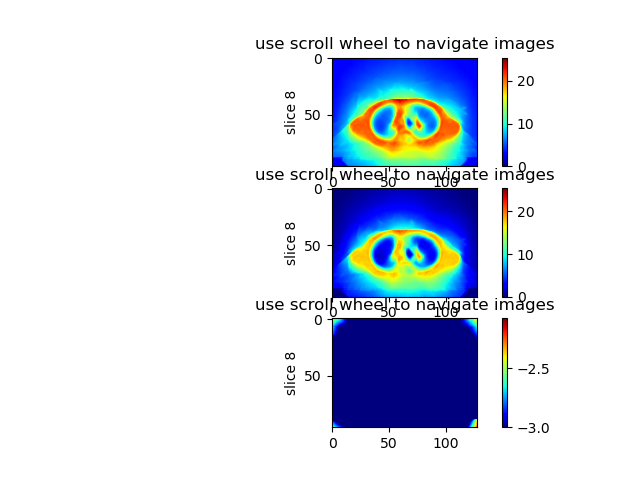

<IPython.core.display.Javascript object>


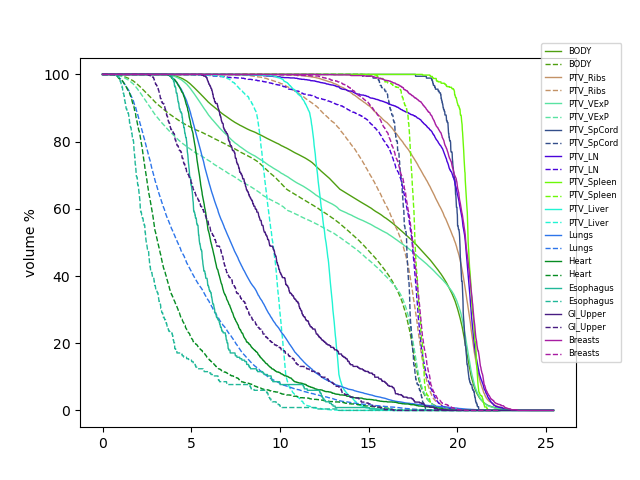

,Organ,Dmean,Dmax,D95,D98,D5,D2
0,BODY,-0.193758,-0.117984,-0.558992,-0.631114,-0.141894,-0.139306
1,PTV_Ribs,-0.158370,-0.124303,-0.216524,-0.236648,-0.139356,-0.136327
2,PTV_VExP,-0.203921,-0.117984,-0.592234,-0.661523,-0.141851,-0.139318
3,PTV_SpCord,-0.149837,-0.141505,-0.158884,-0.161391,-0.143705,-0.142484
4,PTV_LN,-0.152830,-0.130137,-0.216524,-0.250005,-0.138725,-0.136348
5,PTV_Spleen,-0.145635,-0.138078,-0.151342,-0.159049,-0.141195,-0.139891
6,PTV_Liver,-0.239723,-0.182942,-0.275634,-0.293291,-0.217251,-0.208527
7,Lungs,-0.370010,-0.133291,-0.667682,-0.730495,-0.202778,-0.171867
8,Heart,-0.427630,-0.150641,-0.674914,-0.725896,-0.229414,-0.177849
9,Esophagus,-0.482401,-0.183984,-0.724032,-0.750795,-0.244116,-0.234592


In [58]:
predict_unit_test()

(0,)